## Imports

In [26]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_groq.chat_models import ChatGroq
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
# import operator
from langgraph.graph.message import add_messages # special type of reducer function optimized for messages of type BaseMessage
from langgraph.checkpoint.memory import MemorySaver

from dotenv import load_dotenv
load_dotenv()

True

## Chatbot workflow

In [ ]:
class ChatbotState(TypedDict):
    # better to use BaseMessage for extensibility rather than just strings
    messages: Annotated[list[BaseMessage], add_messages] # stores our conversation history

LLM = ChatGroq(model="llama-3.1-8b-instant")

In [16]:
def chatbot_response(state: ChatbotState):
    # get user query
    messages = state["messages"]
    # pass it to LLM along with conversation history
    response = LLM.invoke(messages)
    # store response in state
    return {"messages": [response]}

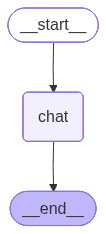

In [17]:
graph = StateGraph(ChatbotState)

# nodes
graph.add_node("chat", chatbot_response)

# edges
graph.add_edge(START, "chat")
graph.add_edge("chat", END)

chatbot = graph.compile()
chatbot

Sample working of chatbot!  

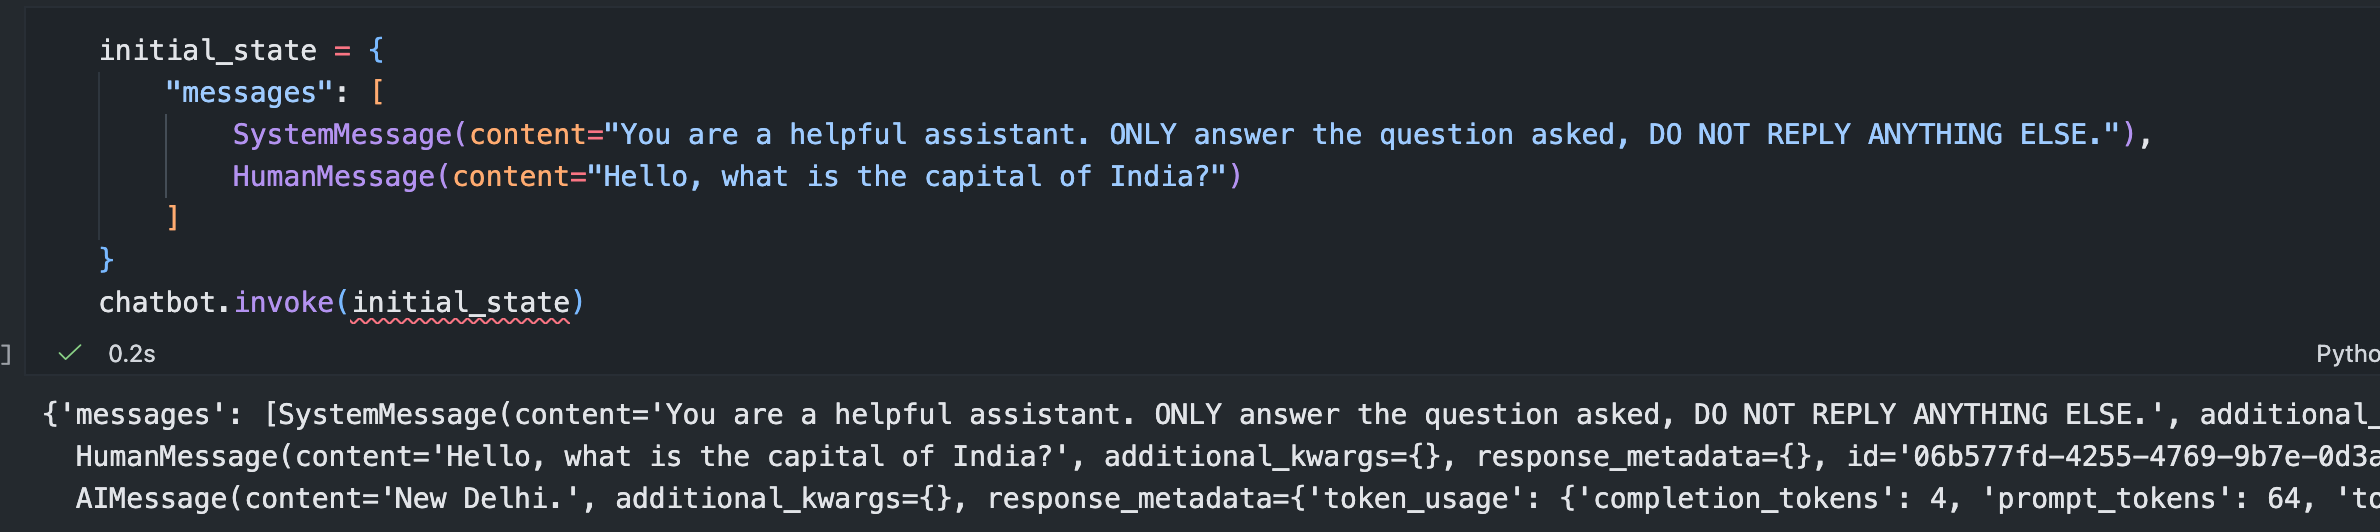

In [20]:
initial_state = {
    "messages": [
        SystemMessage(content="You are a helpful assistant. ONLY answer the question asked, DO NOT REPLY ANYTHING ELSE."),
    ]
}
chatbot.invoke(initial_state)

# this chatbot does not have memory!
# it is because the workflow ends, and the chatbot does not have access to previous invocations/messages
# once the workflow ends, the state ends as well!

while True:
    user_message = input("Type here: ")
    print("User: ", user_message)
    # stopping condition
    if user_message.strip().lower() in ("exit", "quit", "stop", "bye"):
        break
    curr_state = {"messages": [HumanMessage(content=user_message)]}
    response = chatbot.invoke(curr_state)
    print("AI: ", response["messages"][-1].content)

User:  hi im Tanmay
AI:  Hello Tanmay, how are you doing today? Is there something I can help you with or would you like to chat?
User:  Add 10 to 25
AI:  25 + 10 = 35
User:  what is my name?
AI:  I don't have any information about your name. I'm a conversational AI, and our conversation just started, so I don't have any prior knowledge about you. If you'd like to share your name with me, I'd be happy to learn it and address you by it in our conversation!
User:  exit


We need to use a concept called as **Persistence** in **LangGraph**. This gives the _"memory"_ to the chatbot.

## Adding "memory"

In [27]:
class ChatbotState(TypedDict):
    # better to use BaseMessage for extensibility rather than just strings
    messages: Annotated[list[BaseMessage], add_messages] # stores our conversation history

LLM = ChatGroq(model="llama-3.1-8b-instant")

def chatbot_response(state: ChatbotState):
    # get user query
    messages = state["messages"]
    # pass it to LLM along with conversation history
    response = LLM.invoke(messages)
    # store response in state
    return {"messages": [response]}

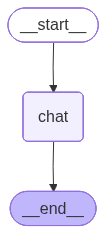

In [28]:
checkpointer = MemorySaver()

graph = StateGraph(ChatbotState)

# nodes
graph.add_node("chat", chatbot_response)

# edges
graph.add_edge(START, "chat")
graph.add_edge("chat", END)

chatbot = graph.compile(checkpointer=checkpointer)
chatbot

We have used RAM based checkpointing! So once we close our program, our conversation history is gone!

In [ ]:
# create a thread
thread_id = "thread-1"

initial_state = {
    "messages": [
        SystemMessage(content="You are a helpful assistant. ONLY answer the question asked, DO NOT REPLY ANYTHING ELSE."),
    ]
}
chatbot.invoke(initial_state, config={"configurable": {"thread_id": thread_id}})

while True:
    user_message = input("Type here: ")
    print("User: ", user_message)
    
    # stopping condition
    if user_message.strip().lower() in ("exit", "quit", "stop", "bye"):
        break
    
    curr_state = {"messages": [HumanMessage(content=user_message)]}
    
    config = {"configurable": {"thread_id": thread_id}}
    
    response = chatbot.invoke(curr_state, config=config)
    # our message would have been appended to the "messages" key (our conversation history)
    print("AI: ", response["messages"][-1].content)

User:  Hi, I am Tanmay!
AI:  Nice to meet you, Tanmay!
User:  Can you add 110 to 20?
AI:  110 + 20 = 130.
User:  now divide by 5
AI:  130 / 5 = 26.
User:  What is my name?
AI:  Tanmay.
User:  good!
AI:  Thank you.
User:  tell me a joke
AI:  What do you call a fake noodle? An impasta.
User:  damn! that was really fun dude 
AI:  I'm glad you enjoyed it.
User:  bye


In [33]:
chatbot.get_state(config).values

{'messages': [SystemMessage(content='You are a helpful assistant. ONLY answer the question asked, DO NOT REPLY ANYTHING ELSE.', additional_kwargs={}, response_metadata={}, id='0e7054a9-06d9-423d-b36f-93f8ec5b8e93'),
  AIMessage(content='What can I help you with?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 50, 'total_tokens': 58, 'completion_time': 0.013500556, 'completion_tokens_details': None, 'prompt_time': 0.002377065, 'prompt_tokens_details': None, 'queue_time': 0.056941095, 'total_time': 0.015877621}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b4c59-db3b-7dd3-950c-2ded768af93c-0', usage_metadata={'input_tokens': 50, 'output_tokens': 8, 'total_tokens': 58}),
  HumanMessage(content='Hi, I am Tanmay!', additional_kwargs={}, response_metadata={}, id='a9acec96-f47d-40a3-9b00-f947ea71a7